Hopefully this notebook is now a working example of the multinomial player model.

In [1]:
import os

import pandas as pd

import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt


Get a sample of player data.  Just look at forwards, with data up to the middle of the 2019/20 season.

In [14]:
from airsenal.framework.prediction_utils import process_player_data
from airsenal.framework.utils import get_player, NEXT_GAMEWEEK
from airsenal.framework.season import CURRENT_SEASON

In [3]:
def get_player_data(position, season="1920", latest_gameweek=38):
    data = process_player_data(position, season, latest_gameweek)
    return data

In [4]:
data = get_player_data("FWD")

Filling history dataframe for Sergio Agüero: 0/87 done
Filling history dataframe for Pierre-Emerick Aubameyang: 1/87 done
Filling history dataframe for Harry Kane: 2/87 done
Filling history dataframe for Jamie Vardy: 3/87 done
Filling history dataframe for Gabriel Fernando de Jesus: 4/87 done
Filling history dataframe for Roberto Firmino: 5/87 done
Filling history dataframe for Alexandre Lacazette: 6/87 done
Filling history dataframe for Marcus Rashford: 7/87 done
Filling history dataframe for Romelu Lukaku: 8/87 done
Filling history dataframe for Raúl Jiménez: 9/87 done
Filling history dataframe for Tammy Abraham: 10/87 done
Filling history dataframe for Callum Wilson: 11/87 done
Filling history dataframe for Danny Ings: 12/87 done
Filling history dataframe for Marko Arnautovic: 13/87 done
Filling history dataframe for Sébastien Haller: 14/87 done
Filling history dataframe for Olivier Giroud: 15/87 done
Filling history dataframe for Michy Batshuayi: 16/87 done
Filling history datafram

this gives us a dict with keys:
```
"player_ids" (list of ints),
"nplayer" (int), 
"nmatch" (int), 
"minutes" (numpy array with shape (nplayer, nmatch)), 
"y" (numpy array with shape (nplayer, nmatch, 3)), 
"alpha" (numpy array with shape (3,))
```


### numpyro model

The below took a lot of iterations to figure out how to broadcast over the right dimensions.
Hopefully it's sort-of right...


In [5]:
def model(nplayer, nmatch, minutes, y, alpha):
    theta = dist.Dirichlet(concentration=alpha)
    # one sample from the prior per player
    with numpyro.plate("nplayer", nplayer) as player_index:
        dprobs = numpyro.sample("probs", theta) 
    # now it's all about how to broadcast in the right dimensions.....
    prob_score = numpyro.deterministic("prob_score",dprobs[:,0,None] * (minutes / 90.))
    prob_assist = numpyro.deterministic("prob_assist",dprobs[:,1,None] * (minutes / 90.))
    prob_neither = numpyro.deterministic("prob_neither",dprobs[:,2,None] * (minutes / 90.) + (90. - minutes))
    theta_mins = dist.Multinomial(
                probs=jnp.moveaxis(jnp.array([prob_score, prob_assist, prob_neither]),0,2)
    )
    return numpyro.sample("obs", theta_mins, obs=y)

In [6]:
def fit_model(data, model):
    kernel = NUTS(model)
    mcmc = MCMC(
    kernel,
    num_warmup=1500,
    num_samples=3000,
    num_chains=1,
    progress_bar=True
    )
    rng_key, rng_key_predict = random.split(random.PRNGKey(44))
    mcmc.run(rng_key,
         data["nplayer"],
         data["nmatch"],
         data["minutes"],
         data["y"],
         data["alpha"]
    )
    return mcmc.get_samples()

In [7]:
def get_probs(player_index, samples):
    prob_score = float(samples["probs"][:,player_index,0].mean())
    prob_assist = float(samples["probs"][:,player_index,1].mean())
    prob_neither = float(samples["probs"][:,player_index,2].mean())
    return (prob_score, prob_assist, prob_neither)

In [8]:
def create_dataframe(names, samples):
    prob_dict = {"name":[],"prob_score": [], "prob_assist": [], "prob_neither": []}
    for i, pid in enumerate(names):
        pid = int(pid)
        prob_dict["name"].append(get_player(pid).name)
        probs = get_probs(i, samples)
        prob_dict["prob_score"].append(probs[0])
        prob_dict["prob_assist"].append(probs[1])
        prob_dict["prob_neither"].append(probs[2])
    df = pd.DataFrame(prob_dict)
    return df

In [9]:
def run_model(position="FWD",season="1920",latest_gameweek=38):
    data = get_player_data(position, season, latest_gameweek)
    samples = fit_model(data, model)
    df = create_dataframe(data["player_ids"], samples)
    return df

Now go through the whole chain for each position in turn

In [115]:
df_fwd = run_model("FWD", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)
df_mid = run_model("MID", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)
df_def = run_model("DEF", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)

Filling history dataframe for Harry Kane: 0/67 done
Filling history dataframe for Jamie Vardy: 1/67 done
Filling history dataframe for Pierre-Emerick Aubameyang: 2/67 done
Filling history dataframe for Timo Werner: 3/67 done
Filling history dataframe for Roberto Firmino: 4/67 done
Filling history dataframe for Alexandre Lacazette: 5/67 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/67 done
Filling history dataframe for Edinson Cavani: 7/67 done
Filling history dataframe for Danny Ings: 8/67 done
Filling history dataframe for Dominic Calvert-Lewin: 9/67 done
Filling history dataframe for Patrick Bamford: 10/67 done
Filling history dataframe for Anthony Martial: 11/67 done
Filling history dataframe for Ollie Watkins: 12/67 done
Filling history dataframe for Richarlison de Andrade: 13/67 done
Filling history dataframe for Kelechi Iheanacho: 14/67 done
Filling history dataframe for Patson Daka: 15/67 done
Filling history dataframe for Callum Wilson: 16/67 done
Filling hist

sample: 100%|████████████| 4500/4500 [00:11<00:00, 375.69it/s, 7 steps of size 4.86e-01. acc. prob=0.80]


Filling history dataframe for Mohamed Salah: 0/220 done
Filling history dataframe for Sadio Mané: 1/220 done
Filling history dataframe for Kevin De Bruyne: 2/220 done
Filling history dataframe for Bruno Miguel Borges Fernandes: 3/220 done
Filling history dataframe for Raheem Sterling: 4/220 done
Filling history dataframe for Heung-Min Son: 5/220 done
Filling history dataframe for Marcus Rashford: 6/220 done
Filling history dataframe for Jadon Sancho: 7/220 done
Filling history dataframe for Riyad Mahrez: 8/220 done
Filling history dataframe for Kai Havertz: 9/220 done
Filling history dataframe for Christian Pulisic: 10/220 done
Filling history dataframe for Jack Grealish: 11/220 done
Filling history dataframe for Phil Foden: 12/220 done
Filling history dataframe for Nicolas Pépé: 13/220 done
Filling history dataframe for Hakim Ziyech: 14/220 done
Filling history dataframe for Mason Mount: 15/220 done
Filling history dataframe for Diogo Jota: 16/220 done
Filling history dataframe for Il

Alpha is [ 9.20967011  9.09309201 66.37465724]


sample: 100%|███████████| 4500/4500 [00:35<00:00, 126.51it/s, 15 steps of size 2.84e-01. acc. prob=0.87]


Filling history dataframe for Trent Alexander-Arnold: 0/180 done
Filling history dataframe for Andrew Robertson: 1/180 done
Filling history dataframe for Virgil van Dijk: 2/180 done
Filling history dataframe for César Azpilicueta: 3/180 done
Filling history dataframe for Benjamin Chilwell: 4/180 done
Filling history dataframe for João Pedro Cavaco Cancelo: 5/180 done
Filling history dataframe for Rúben Santos Gato Alves Dias: 6/180 done
Filling history dataframe for Thiago Emiliano da Silva: 7/180 done
Filling history dataframe for Marcos Alonso: 8/180 done
Filling history dataframe for Antonio Rüdiger: 9/180 done
Filling history dataframe for Kurt Zouma: 10/180 done
Filling history dataframe for Reece James: 11/180 done
Filling history dataframe for Lucas Digne: 12/180 done
Filling history dataframe for Jonny Evans: 13/180 done
Filling history dataframe for Ricardo Domingos Barbosa Pereira: 14/180 done
Filling history dataframe for Timothy Castagne: 15/180 done
Filling history datafra

sample: 100%|███████████| 4500/4500 [00:30<00:00, 148.90it/s, 15 steps of size 2.59e-01. acc. prob=0.89]


Text(0, 0.5, 'P(assist)')

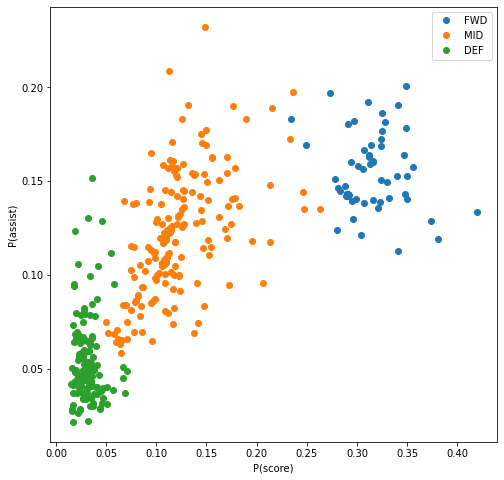

In [116]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plt.plot(df_fwd['prob_score'], df_fwd['prob_assist'], 'o', label='FWD')
plt.plot(df_mid['prob_score'], df_mid['prob_assist'], 'o', label='MID')
plt.plot(df_def['prob_score'], df_def['prob_assist'], 'o', label='DEF')
plt.legend()
plt.xlabel('P(score)')
plt.ylabel('P(assist)')


In [117]:
df_fwd.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
7,Danny Ings,0.419006,0.133731,0.447263
17,Chris Wood,0.380964,0.119381,0.499655
0,Pierre-Emerick Aubameyang,0.374010,0.128854,0.497136
19,Olivier Giroud,0.356051,0.157327,0.486622
26,Dominic Calvert-Lewin,0.349573,0.140500,0.509926
22,Tammy Abraham,0.349531,0.152698,0.497770
64,Raúl Jiménez,0.348702,0.178484,0.472813
37,Anthony Martial,0.348614,0.201009,0.450377
51,Harry Kane,0.348130,0.143002,0.508868
28,Jamie Vardy,0.346544,0.164212,0.489244


In [118]:
df_mid.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
115,Mohamed Salah,0.263217,0.135257,0.601525
113,Sadio Mané,0.247171,0.134980,0.617849
118,Diogo Jota,0.246123,0.144510,0.609367
178,Heung-Min Son,0.236003,0.197724,0.566273
138,Marcus Rashford,0.233239,0.172716,0.594045
137,Bruno Miguel Borges Fernandes,0.215141,0.189257,0.595602
125,Raheem Sterling,0.213007,0.147724,0.639269
91,Ayoze Pérez,0.212885,0.117487,0.669628
142,Mason Greenwood,0.206455,0.095866,0.697679
19,Anwar El Ghazi,0.194924,0.118159,0.686917


In [119]:
data_fwd = get_player_data("FWD", CURRENT_SEASON, NEXT_GAMEWEEK)

Filling history dataframe for Harry Kane: 0/67 done
Filling history dataframe for Jamie Vardy: 1/67 done
Filling history dataframe for Pierre-Emerick Aubameyang: 2/67 done
Filling history dataframe for Timo Werner: 3/67 done
Filling history dataframe for Roberto Firmino: 4/67 done
Filling history dataframe for Alexandre Lacazette: 5/67 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/67 done
Filling history dataframe for Edinson Cavani: 7/67 done
Filling history dataframe for Danny Ings: 8/67 done
Filling history dataframe for Dominic Calvert-Lewin: 9/67 done
Filling history dataframe for Patrick Bamford: 10/67 done
Filling history dataframe for Anthony Martial: 11/67 done
Filling history dataframe for Ollie Watkins: 12/67 done
Filling history dataframe for Richarlison de Andrade: 13/67 done
Filling history dataframe for Kelechi Iheanacho: 14/67 done
Filling history dataframe for Patson Daka: 15/67 done
Filling history dataframe for Callum Wilson: 16/67 done
Filling hist

In [120]:
from scipy.stats import dirichlet

prior = dirichlet(data_fwd["alpha"])
sample = prior.rvs(1000)

Text(0.5, 1.0, 'p_neither')

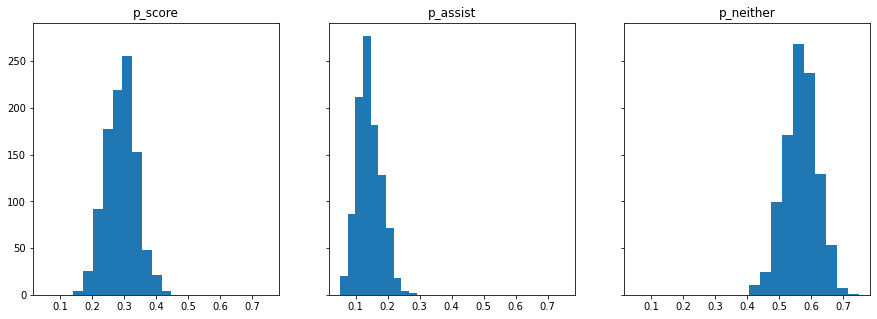

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].hist(sample[:, 0])
ax[0].set_title("p_score")
ax[1].hist(sample[:, 1])
ax[1].set_title("p_assist")
ax[2].hist(sample[:, 2])
ax[2].set_title("p_neither")

In [147]:
from airsenal.framework.prediction_utils import get_empirical_bayes_estimates, get_player_history_df

df = get_player_history_df(
    "FWD", season=CURRENT_SEASON, gameweek=NEXT_GAMEWEEK
)
df["neither"] = df["team_goals"] - df["goals"] - df["assists"]
df.loc[(df["neither"] < 0), ["neither", "team_goals", "goals", "assists"]] = [
    0.0,
    0.0,
    0.0,
    0.0,
]

emp_fwd = {}
for idx, data in df.groupby("player_id"):
    print(data["player_name"].iloc[0])
    alpha = get_empirical_bayes_estimates(data)
    emp_fwd[idx] = alpha / alpha.sum()

emp_fwd = pd.DataFrame(emp_fwd).T
emp_fwd.columns = ["emp_score", "emp_assist", "emp_neither"]
emp_fwd["name"] = [get_player(idx).name for idx in emp_fwd.index]
emp_fwd

Filling history dataframe for Harry Kane: 0/67 done
Filling history dataframe for Jamie Vardy: 1/67 done
Filling history dataframe for Pierre-Emerick Aubameyang: 2/67 done
Filling history dataframe for Timo Werner: 3/67 done
Filling history dataframe for Roberto Firmino: 4/67 done
Filling history dataframe for Alexandre Lacazette: 5/67 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/67 done
Filling history dataframe for Edinson Cavani: 7/67 done
Filling history dataframe for Danny Ings: 8/67 done
Filling history dataframe for Dominic Calvert-Lewin: 9/67 done
Filling history dataframe for Patrick Bamford: 10/67 done
Filling history dataframe for Anthony Martial: 11/67 done
Filling history dataframe for Ollie Watkins: 12/67 done
Filling history dataframe for Richarlison de Andrade: 13/67 done
Filling history dataframe for Kelechi Iheanacho: 14/67 done
Filling history dataframe for Patson Daka: 15/67 done
Filling history dataframe for Callum Wilson: 16/67 done
Filling hist

/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:478: RuntimeWarning: invalid value encountered in long_scalars
  a0 = neff * (goals / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:479: RuntimeWarning: invalid value encountered in long_scalars
  a1 = neff * (assists / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:483: RuntimeWarning: invalid value encountered in long_scalars
  * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:478: RuntimeWarning: divide by zero encountered in long_scalars
  a0 = neff * (goals / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:478: RuntimeWarning: invalid value encountered in double_scalars
  a0 = neff * (goals / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils

Alpha is [41.35074939 21.89157321 50.75767741]
[41.35074939 21.89157321 50.75767741]
Fabio Silva
Alpha is [10.68047337  8.01035503 19.3091716 ]
[10.68047337  8.01035503 19.3091716 ]
Patrick Cutrone
Alpha is [28.82815735  0.         30.17184265]
[28.82815735  0.         30.17184265]


,emp_score,emp_assist,emp_neither,name
4,0.367744,0.102151,0.530105,Pierre-Emerick Aubameyang
6,0.319648,0.195341,0.485011,Alexandre Lacazette
20,0.264528,0.052906,0.682567,Edward Nketiah
42,0.261582,0.168160,0.570258,Ollie Watkins
49,0.198247,0.039649,0.762104,Wesley Moraes
...,...,...,...,...
473,NaN,NaN,NaN,Juan Camilo Hernández Suárez
482,0.280618,0.183481,0.535901,Michail Antonio
502,0.362726,0.192031,0.445243,Raúl Jiménez
517,0.281065,0.210799,0.508136,Fabio Silva


In [131]:
emp_fwd

,emp_score,emp_assist,emp_neither,name
4,0.367744,0.102151,0.530105,Pierre-Emerick Aubameyang
6,0.319648,0.195341,0.485011,Alexandre Lacazette
20,0.264528,0.052906,0.682567,Edward Nketiah
42,0.261582,0.168160,0.570258,Ollie Watkins
49,0.198247,0.039649,0.762104,Wesley Moraes
...,...,...,...,...
473,NaN,NaN,NaN,Juan Camilo Hernández Suárez
482,0.280618,0.183481,0.535901,Michail Antonio
502,0.362726,0.192031,0.445243,Raúl Jiménez
517,0.281065,0.210799,0.508136,Fabio Silva


In [128]:
df_fit = pd.merge(df_fwd, emp_fwd, on="name", how="inner")
df_fit.set_index("name", inplace=True)

In [130]:
(df_fit["prob_score"] - df_fit["emp_score"]).dropna().sort_values()

name
Patrick Cutrone                       -0.181681
Teemu Pukki                           -0.169515
Jean-Philippe Mateta                  -0.119288
Florin Andone                         -0.063258
Harry Kane                            -0.026978
Danny Ings                            -0.025222
Callum Wilson                         -0.015650
Edinson Cavani                        -0.015516
Troy Deeney                           -0.014102
Raúl Jiménez                          -0.014023
Jamie Vardy                           -0.012813
Chris Wood                            -0.012560
Michael Obafemi                       -0.011537
Ashley Barnes                         -0.011489
Tammy Abraham                         -0.000793
Andre Gray                             0.005105
Pierre-Emerick Aubameyang              0.006266
Neal Maupay                            0.008024
Dominic Calvert-Lewin                  0.008498
Rodrigo Moreno                         0.013557
Ollie Watkins                      

Text(0.5, 1.0, 'Player Posterior p_neither')

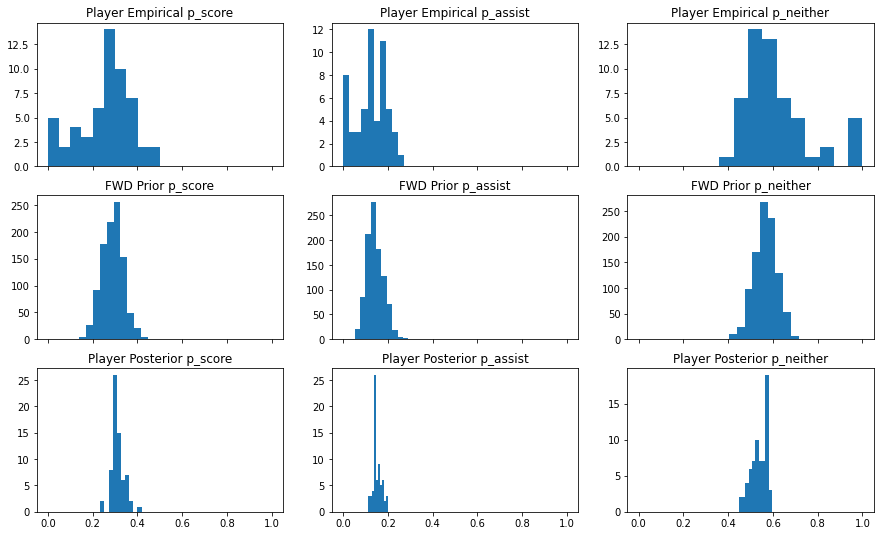

In [143]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=False)
ax[0, 0].hist(emp_fwd["emp_score"])
ax[0, 0].set_title("Player Empirical p_score")
ax[0, 1].hist(emp_fwd["emp_assist"])
ax[0, 1].set_title("Player Empirical p_assist")
ax[0, 2].hist(emp_fwd["emp_neither"])
ax[0, 2].set_title("Player Empirical p_neither")

ax[1, 0].hist(sample[:, 0])
ax[1, 0].set_title("FWD Prior p_score")
ax[1, 1].hist(sample[:, 1])
ax[1, 1].set_title("FWD Prior p_assist")
ax[1, 2].hist(sample[:, 2])
ax[1, 2].set_title("FWD Prior p_neither")

ax[2, 0].hist(df_fwd["prob_score"])
ax[2, 0].set_title("Player Posterior p_score")
ax[2, 1].hist(df_fwd["prob_assist"])
ax[2, 1].set_title("Player Posterior p_assist")
ax[2, 2].hist(df_fwd["prob_neither"])
ax[2, 2].set_title("Player Posterior p_neither")

In [141]:
# empirical
emp_fwd["emp_score"].describe()

count    55.000000
mean      0.257673
std       0.122412
min       0.000000
25%       0.201862
50%       0.280422
75%       0.336923
max       0.501707
Name: emp_score, dtype: float64

In [142]:
# prior
print(sample[:, 0].mean(), sample[:, 0].std())

0.29018462865084715 0.04744173568690675


In [140]:
# posterior
df_fwd["prob_score"].describe()

count    67.000000
mean      0.310563
std       0.030214
min       0.234565
25%       0.290497
50%       0.306193
75%       0.324829
max       0.419006
Name: prob_score, dtype: float64

In [145]:
df_fit.loc["Roberto Firmino"]

prob_score      0.249154
prob_assist     0.169443
prob_neither    0.581402
emp_score       0.150914
emp_assist      0.125761
emp_neither     0.723325
Name: Roberto Firmino, dtype: float64

In [149]:
x = np.array([24.55, 12.04, 47.91])
x.sum()

84.5